# Steps
1. Make data choice.
5. Choose 'fixed' configuration.
6. For each 'fixed' configuration, optimize the other parameters based on RMSE.
7. Given optimal setting, run popularity bias analysis for every version of the 'fixed' configuration.

## Libraries

In [1]:
%env MKL_THREADING_LAYER=tbb
%env OPENBLAS_NUM_THREADS=24
%env NUMBA_NUM_THREADS=96
%env MKL_NUM_THREADS=96
%env OMP_NUM_THREADS=1

env: MKL_THREADING_LAYER=tbb
env: OPENBLAS_NUM_THREADS=24
env: NUMBA_NUM_THREADS=96
env: MKL_NUM_THREADS=96
env: OMP_NUM_THREADS=1


In [2]:
import os

os.environ["MKL_THREADING_LAYER"] = "tbb"
os.environ["OPENBLAS_NUM_THREADS"] = "24"
os.environ["NUMBA_NUM_THREADS"] = "96"
os.environ["MKL_NUM_THREADS"] = "96"
os.environ["OMP_NUM_THREADS"] = "1"
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
# for random generation


# basic functions
import pandas as pd

pd.options.display.max_rows = 100
import pickle
import scipy

# custom-made functions
import modelling_mf
from optimize_hp import optimize_lkpy, optimize_cornac

# lenskit RS library
from lenskit.algorithms import als


# cornac RS library
from cornac.models import MF

## Data and parameters

In [3]:
data = "fairbook"
# user-item interactions
fairbook_ratings = pd.read_csv("data/" + data + "_events.csv")

In [4]:
data = "ml1m"
# user-item interactions
ml1m_ratings = pd.read_csv(
    "data/" + data + "_events.dat", header=None, sep="::", engine="python"
).drop(3, axis=1)
ml1m_ratings.columns = ["user", "item", "rating"]

In [5]:
data = "epinion"
mat = scipy.io.loadmat("data/" + data + "_events.mat")
mat_df = pd.DataFrame(mat["rating_with_timestamp"])
mat_df.columns = ["user", "item", ".", "rating", "..", "..."]
epinion_ratings = mat_df[["user", "item", "rating"]]

Make data choice.

In [14]:
ratings = fairbook_ratings.copy()
ratings = ratings.drop_duplicates(subset=["user", "item"], keep="last")
data_strategy = "fairbook"

In [15]:
user_col = "user"  # the name of the column that includes the users
item_col = "item"  # the name of the column that includes the items
predict_col = "rating"  # the name of the column that includes the interaction

In [16]:
evaluation_way = "cross_validation"
verbose = True
plot = True
save_plot = True  # save the plots
fallback = False
nr_recs = 10
sampling_strategy = "frac"
partition_way = "user"

## Optimize, train, evaluate LKPY
- **Algorithm**
- **Fixed parameters**
- **To-optimize parameters**

In [17]:
algo_versions = {"MF": [{"bias": True}, {"bias": False}]}

{'bias': True}
We got them already
0 Training done!
Prediction done!
0 Recommendation done!
nr of longtail 983
0.7727987421383647
1 Training done!
Prediction done!
1 Recommendation done!
nr of longtail 988
0.7767295597484277
2 Training done!
Prediction done!
2 Recommendation done!
nr of longtail 975
0.7665094339622641
3 Training done!
Prediction done!
3 Recommendation done!
nr of longtail 1020
0.8025177025963808
4 Training done!
Prediction done!
4 Recommendation done!
nr of longtail 1118
0.8796223446105429


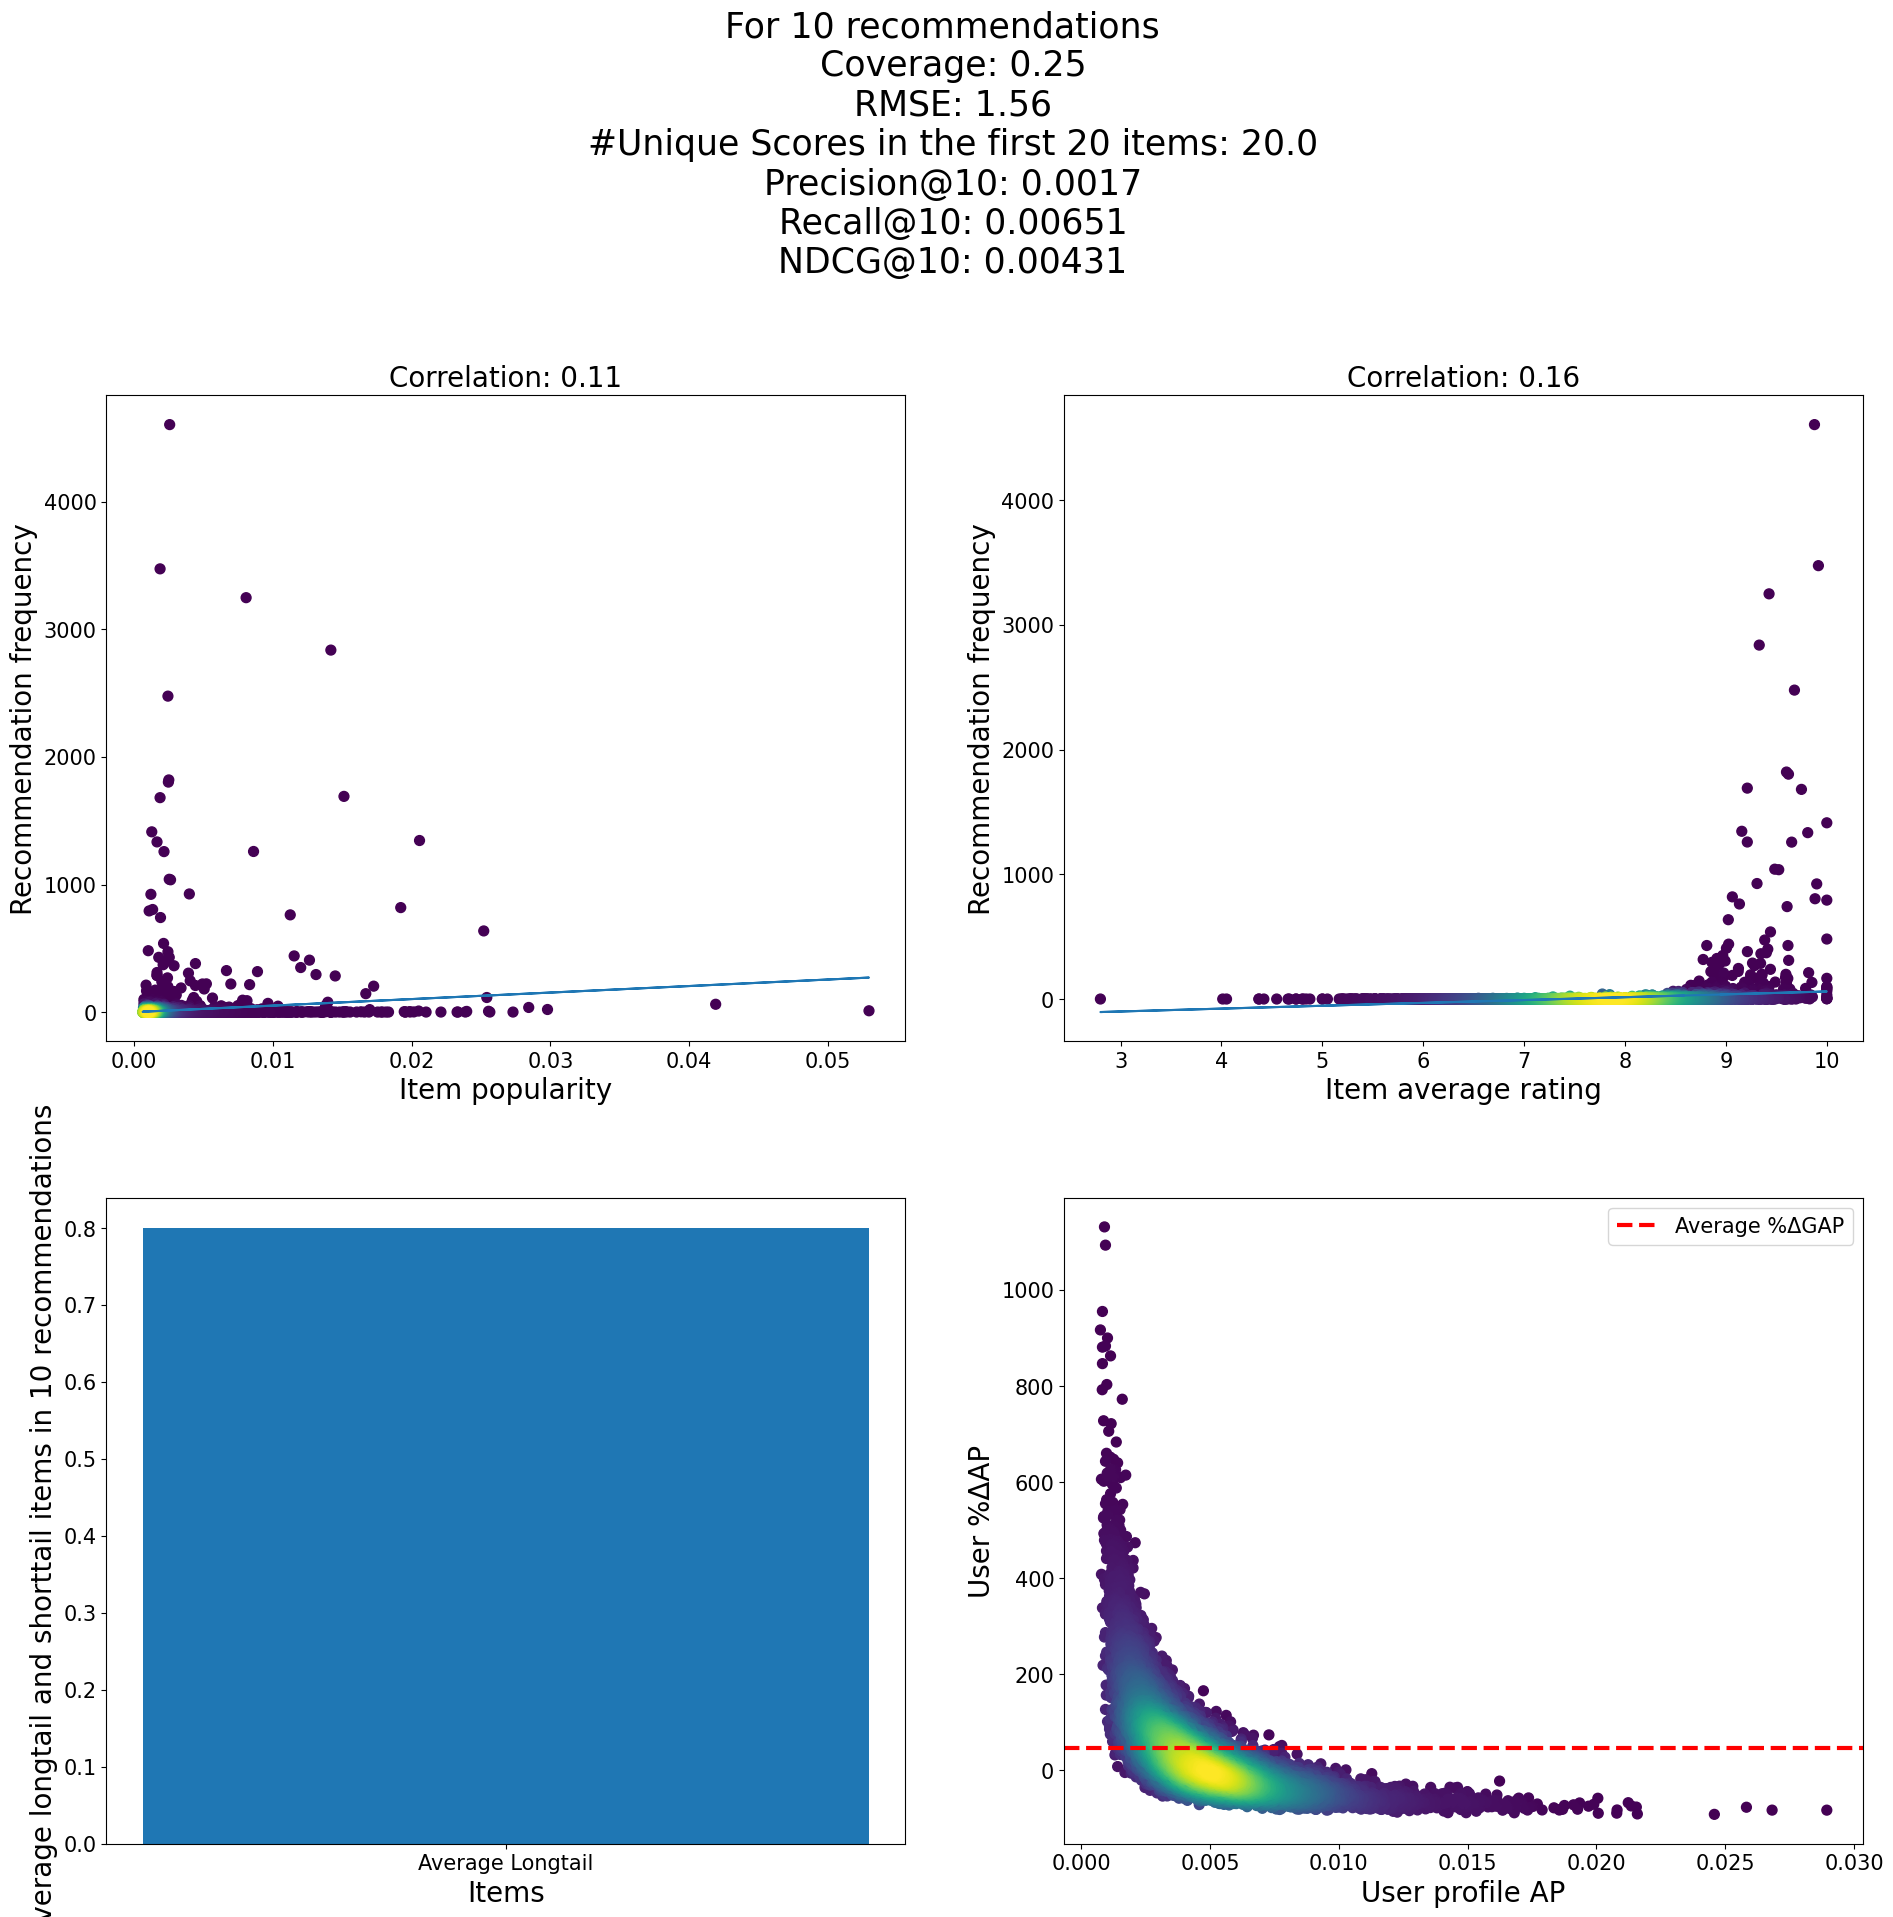

{'bias': False}
We got them already
0 Training done!
Prediction done!
0 Recommendation done!
nr of longtail 6243
4.908018867924528
1 Training done!
Prediction done!
1 Recommendation done!
nr of longtail 6556
5.154088050314465
2 Training done!
Prediction done!
2 Recommendation done!
nr of longtail 7036
5.531446540880503
3 Training done!
Prediction done!
3 Recommendation done!
nr of longtail 8355
6.573564122738001
4 Training done!
Prediction done!
4 Recommendation done!
nr of longtail 6948
5.466561762391818


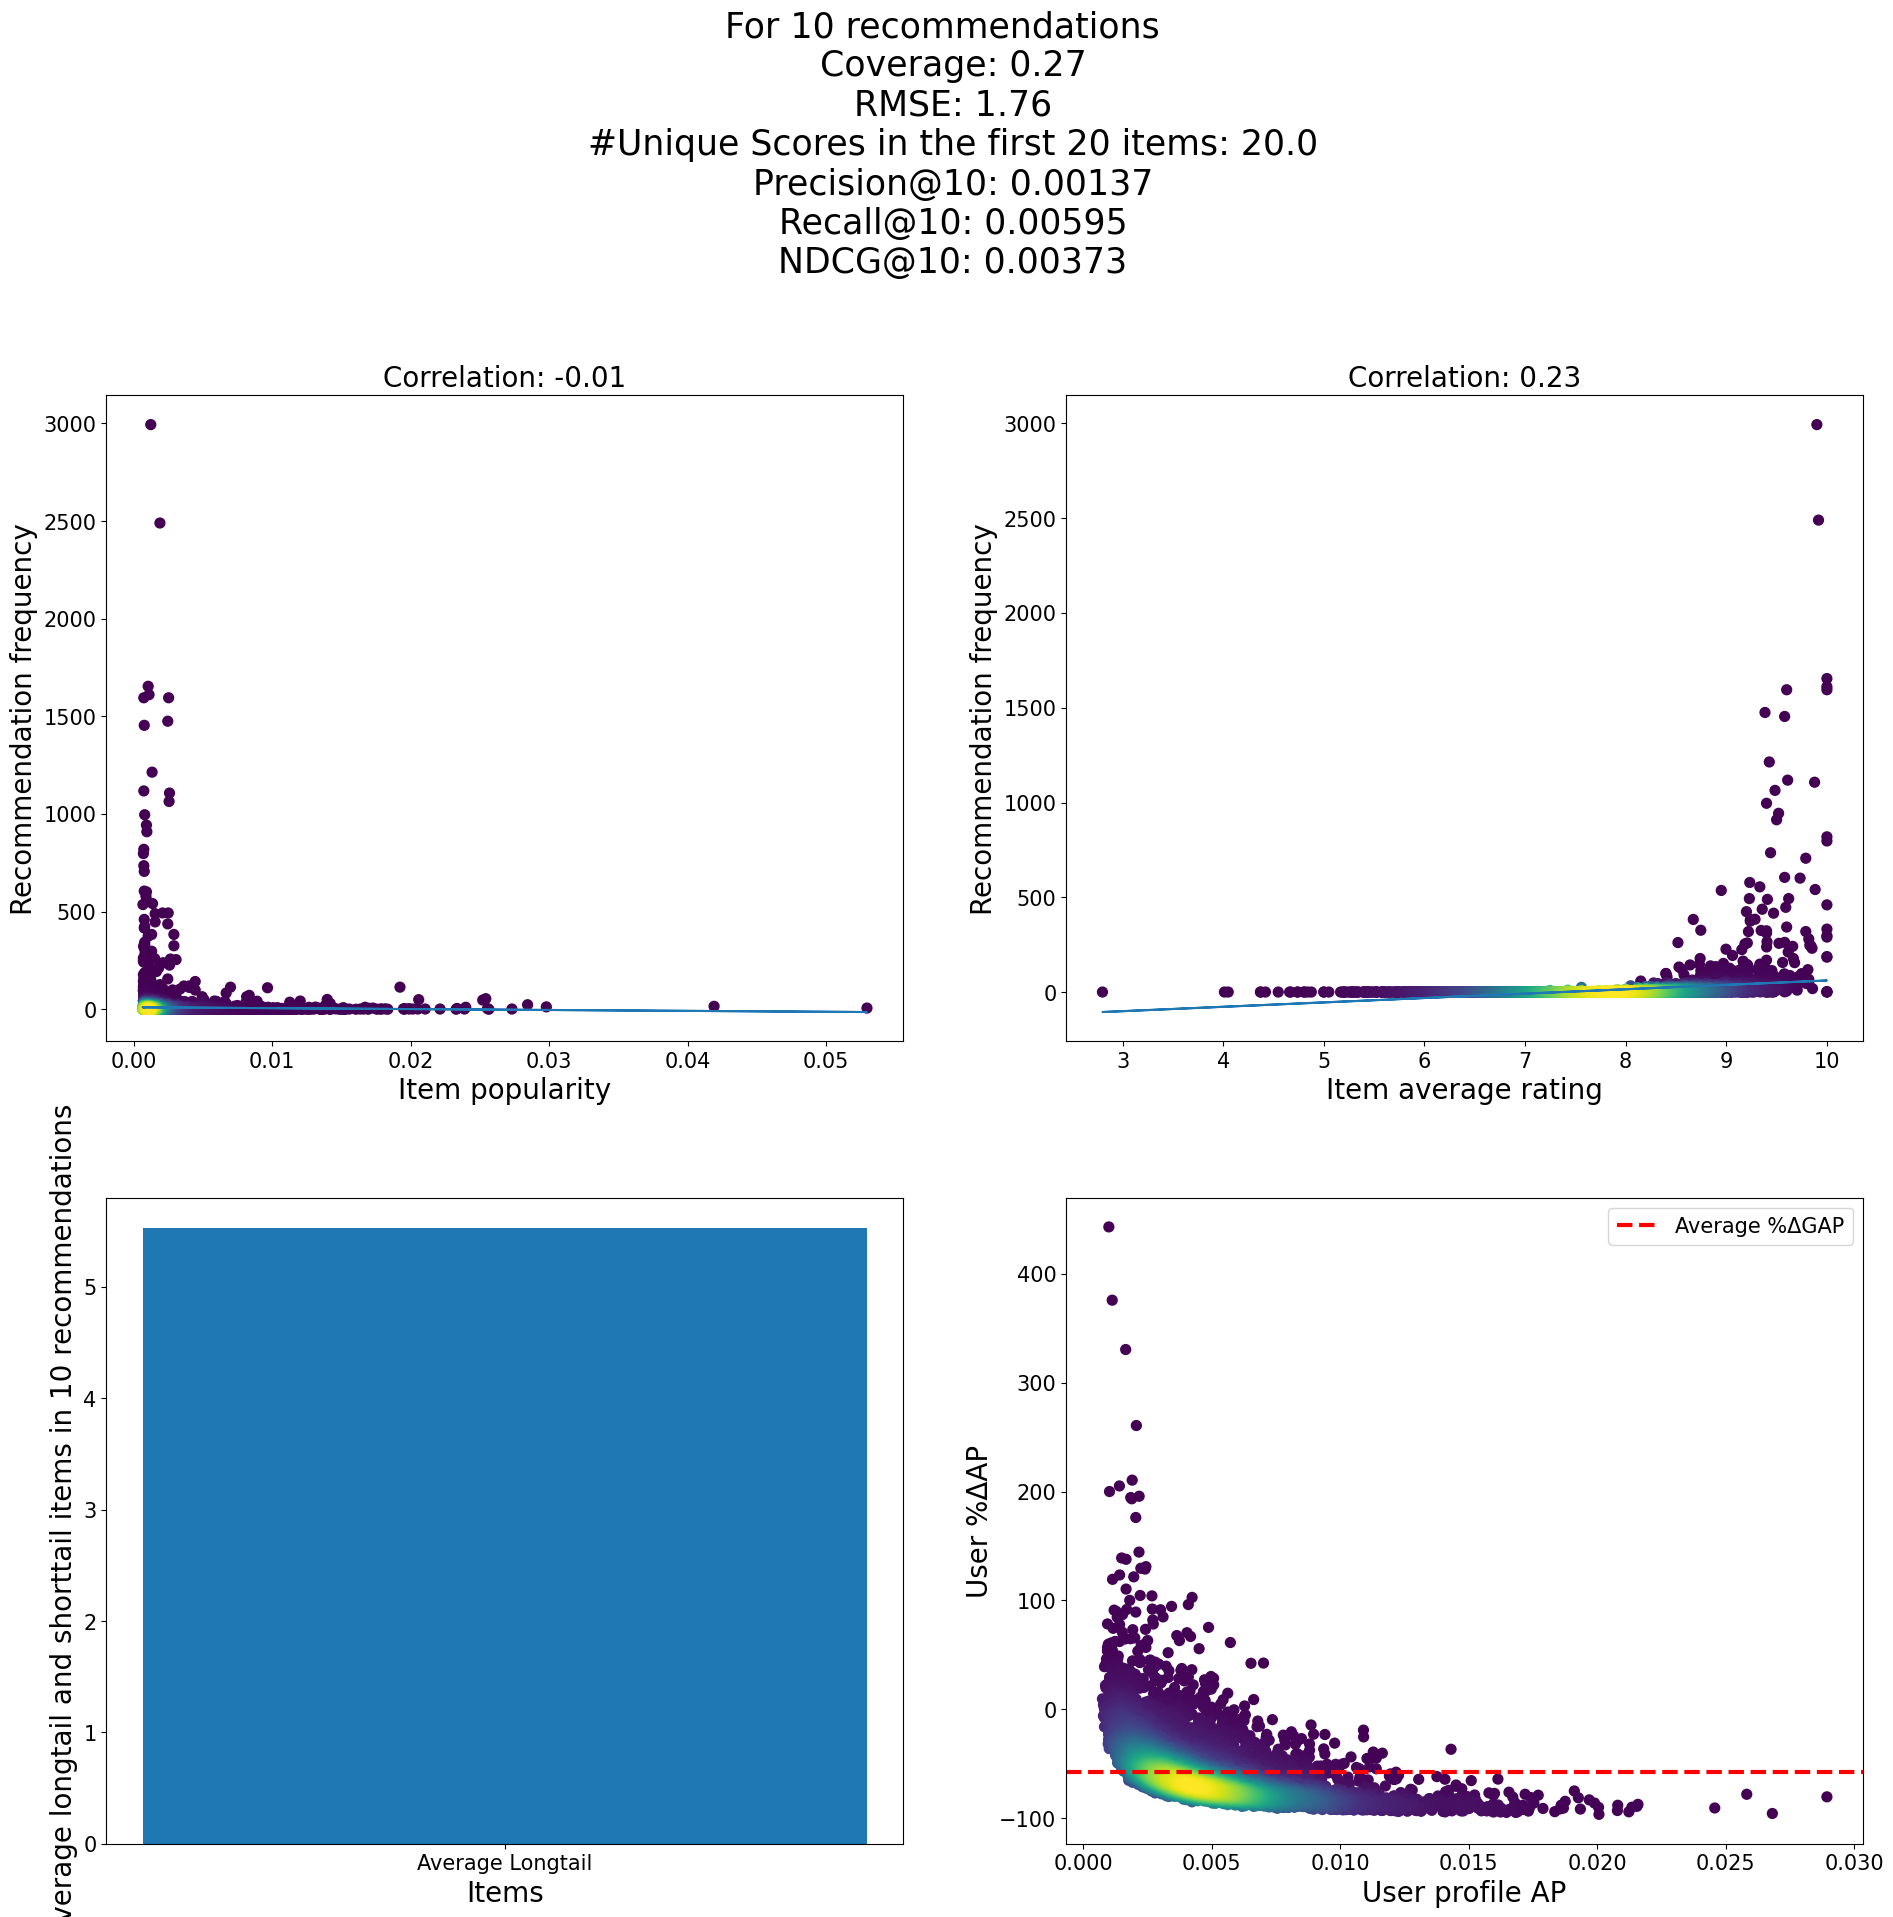

In [18]:
# choose algorithm
algorithm_lkpy = als.BiasedMF
algo_name = "MF"
versions = algo_versions[algo_name]


# for every 'fixed' version of the algorithm
for args in versions:
    print(args)


    p = "best_parameters/" + algo_name + "/" + data_strategy + "_" + str(args) + ".pkl"
    if os.path.isfile(p):
        print("We got them already")
        with open(p, "rb") as f:
            best_params = pickle.load(f)
    else:
        print("We have to compute them now")
        # optimize for this fixed version
        best_params = optimize_lkpy(
            ratings=ratings, algorithm_name=algo_name, args=args, max_evals=20, partition_way = 'row'
        )

        # save the best parameters for this fixed version

        with open(
            "best_parameters/"
            + algo_name
            + "/"
            + data_strategy
            + "_"
            + str(args)
            + ".pkl",
            "wb",
        ) as f:
            pickle.dump(best_params, f)
    
    # # optimize for this fixed version
    # best_params = optimize_lkpy(
    #     ratings=ratings,
    #     algorithm_name=algo_name,
    #     args=args,
    #     partition_way="row",
    #     max_evals=20,
    # )

    # # save the best parameters for this fixed version

    # with open(
    #     "best_parameters/" + algo_name + "/" + data_strategy + "_" + str(args) + ".pkl",
    #     "wb",
    # ) as f:
    #     pickle.dump(best_params, f)

    reg_list = [0, 0.001, 0.01, 0.1]
    features_list = [10, 50, 100]
    optimal_reg = reg_list[best_params["reg"]]
    optimal_features = features_list[best_params["features"]]

    # run the training and evaluation for the fixed version + the best other parameters
    pop_biases_lkpy, metrics_dict_lkpy = modelling_mf.train_algorithm(
        algorithm=lambda: algorithm_lkpy(
            features=optimal_features, reg=optimal_reg, bias=args["bias"]
        ),
        algo_name=algo_name,
        ratings=ratings,
        evaluation_way=evaluation_way,
        verbose=verbose,
        n=nr_recs,
        sampling_strategy=sampling_strategy,
        partition_way=partition_way,
        plot=plot,
        data_strategy=data_strategy,
        args=args,
        save_plot=save_plot,
    )

    # Save metrics!
    with open(
        "experimental_results/"
        + algo_name
        + "/"
        + data_strategy
        + "_"
        + str(args)
        + ".pkl",
        "wb",
    ) as f:
        pickle.dump(metrics_dict_lkpy, f)
    with open('experimental_results/'+algo_name+'/detailed_per_item_'+data_strategy+'_'+str(args)+'.pkl', 'wb') as f:
        pickle.dump(pop_biases_lkpy, f)

## Optimize, train, evaluate Cornac
- **Algorithm**
- **Fixed parameters**
- **To-optimize parameters**

In [19]:
mapping_dict = {}  # Create a dictionary that maps each item to an integer - necessary for Cornac.
i = 0
for mov in ratings[item_col].unique():
    mapping_dict[mov] = i
    i += 1
ratings[item_col] = ratings[item_col].map(
    lambda x: mapping_dict.get(x, x)
)  # Map in the ratings file

In [20]:
algo_versions = {"CornacMF": [{"bias": True}, {"bias": False}]}

fairbook {'bias': True}
We got them already
rating_threshold = 1.0
exclude_unknowns = False
---
Training data:
Number of users = 6358
Number of items = 6921
Number of ratings = 85028
Max rating = 10.0
Min rating = 1.0
Global mean = 7.8
---
Test data:
Number of users = 1272
Number of items = 2361
Number of ratings = 3524
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 6358
Total items = 6921
Splits made!
Experiment made!

[MF] Training started!

[MF] Evaluation started!


Rating:   0%|          | 0/3524 [00:00<?, ?it/s]


TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 1.5523 |    0.4024 |   0.1192

Experiment ran!
Training done!
Recommendation done!
Pop bias!
GAP GAP!
nr of longtail 1268
0.9968553459119497
all metrics!
rating_threshold = 1.0
exclude_unknowns = False
---
Training data:
Number of users = 6358
Number of items = 6921
Number of ratings = 85184
Max rating = 10.0
Min rating = 1.0
Global mean = 7.8
---
Test data:
Number of users = 1272
Number of items = 2281
Number of ratings = 3368
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 6358
Total items = 6921
Splits made!
Experiment made!

[MF] Training started!

[MF] Evaluation started!


Rating:   0%|          | 0/3368 [00:00<?, ?it/s]


TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 1.5430 |    0.3338 |   0.1558

Experiment ran!
Training done!
Recommendation done!
Pop bias!
GAP GAP!
nr of longtail 2543
1.9992138364779874
all metrics!
rating_threshold = 1.0
exclude_unknowns = False
---
Training data:
Number of users = 6358
Number of items = 6921
Number of ratings = 84954
Max rating = 10.0
Min rating = 1.0
Global mean = 7.8
---
Test data:
Number of users = 1272
Number of items = 2388
Number of ratings = 3598
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 6358
Total items = 6921
Splits made!
Experiment made!

[MF] Training started!

[MF] Evaluation started!


Rating:   0%|          | 0/3598 [00:00<?, ?it/s]


TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 1.5219 |    0.2480 |   0.0815

Experiment ran!
Training done!
Recommendation done!
Pop bias!
GAP GAP!
nr of longtail 1271
0.9992138364779874
all metrics!
rating_threshold = 1.0
exclude_unknowns = False
---
Training data:
Number of users = 6358
Number of items = 6921
Number of ratings = 84960
Max rating = 10.0
Min rating = 1.0
Global mean = 7.8
---
Test data:
Number of users = 1271
Number of items = 2398
Number of ratings = 3592
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 6358
Total items = 6921
Splits made!
Experiment made!

[MF] Training started!

[MF] Evaluation started!


Rating:   0%|          | 0/3592 [00:00<?, ?it/s]


TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 1.5510 |    0.2624 |   0.0942

Experiment ran!
Training done!
Recommendation done!
Pop bias!
GAP GAP!
nr of longtail 1268
0.997639653815893
all metrics!
rating_threshold = 1.0
exclude_unknowns = False
---
Training data:
Number of users = 6358
Number of items = 6921
Number of ratings = 85135
Max rating = 10.0
Min rating = 1.0
Global mean = 7.8
---
Test data:
Number of users = 1271
Number of items = 2345
Number of ratings = 3417
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 6358
Total items = 6921
Splits made!
Experiment made!

[MF] Training started!

[MF] Evaluation started!


Rating:   0%|          | 0/3417 [00:00<?, ?it/s]


TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 1.5062 |    1.0144 |   0.1387

Experiment ran!
Training done!
Recommendation done!
Pop bias!
GAP GAP!
nr of longtail 1270
0.999213217938631
all metrics!


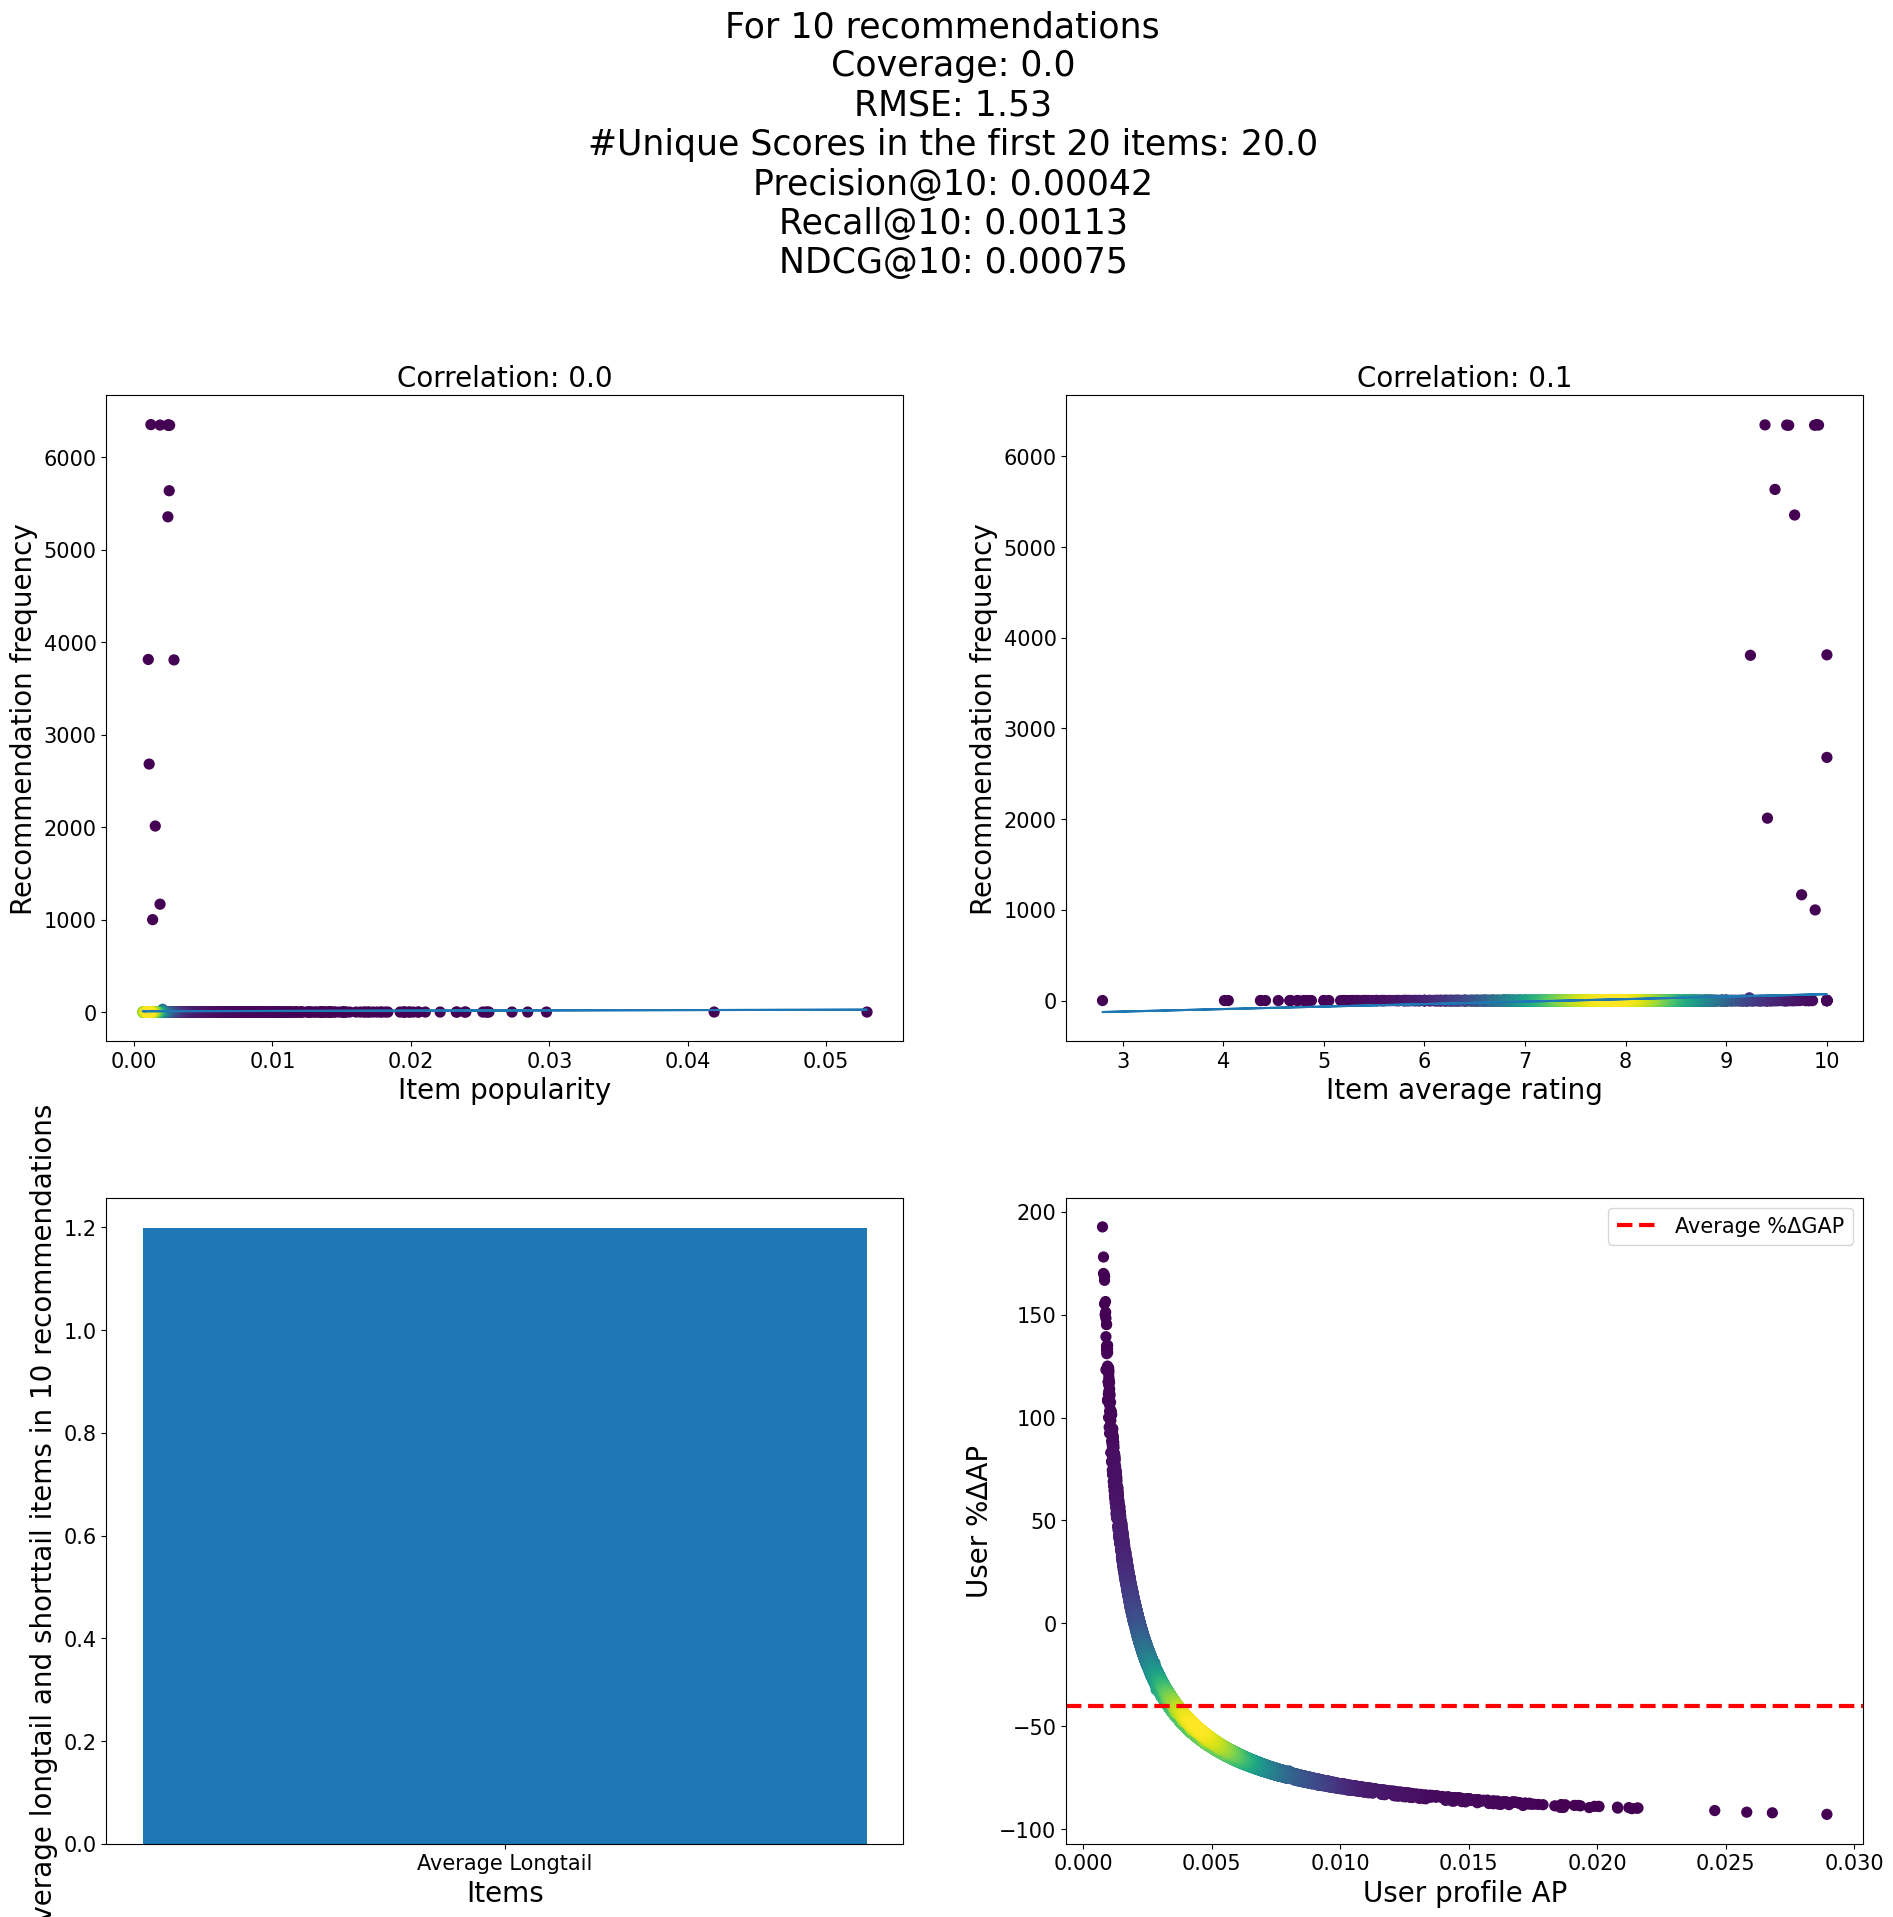

fairbook {'bias': False}
We got them already
rating_threshold = 1.0
exclude_unknowns = False
---
Training data:
Number of users = 6358
Number of items = 6921
Number of ratings = 85028
Max rating = 10.0
Min rating = 1.0
Global mean = 7.8
---
Test data:
Number of users = 1272
Number of items = 2361
Number of ratings = 3524
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 6358
Total items = 6921
Splits made!
Experiment made!

[MF] Training started!

[MF] Evaluation started!


Rating:   0%|          | 0/3524 [00:00<?, ?it/s]


TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 1.6121 |    0.8329 |   0.2843

Experiment ran!
Training done!
Recommendation done!
Pop bias!
GAP GAP!
nr of longtail 7680
6.037735849056604
all metrics!
rating_threshold = 1.0
exclude_unknowns = False
---
Training data:
Number of users = 6358
Number of items = 6921
Number of ratings = 85184
Max rating = 10.0
Min rating = 1.0
Global mean = 7.8
---
Test data:
Number of users = 1272
Number of items = 2281
Number of ratings = 3368
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 6358
Total items = 6921
Splits made!
Experiment made!

[MF] Training started!

[MF] Evaluation started!


Rating:   0%|          | 0/3368 [00:00<?, ?it/s]


TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 1.6013 |    0.0969 |   0.0872

Experiment ran!
Training done!
Recommendation done!
Pop bias!
GAP GAP!
nr of longtail 9706
7.630503144654088
all metrics!
rating_threshold = 1.0
exclude_unknowns = False
---
Training data:
Number of users = 6358
Number of items = 6921
Number of ratings = 84954
Max rating = 10.0
Min rating = 1.0
Global mean = 7.8
---
Test data:
Number of users = 1272
Number of items = 2388
Number of ratings = 3598
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 6358
Total items = 6921
Splits made!
Experiment made!

[MF] Training started!

[MF] Evaluation started!


Rating:   0%|          | 0/3598 [00:00<?, ?it/s]


TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 1.5714 |    0.1011 |   0.0719

Experiment ran!
Training done!
Recommendation done!
Pop bias!
GAP GAP!
nr of longtail 8871
6.974056603773585
all metrics!
rating_threshold = 1.0
exclude_unknowns = False
---
Training data:
Number of users = 6358
Number of items = 6921
Number of ratings = 84960
Max rating = 10.0
Min rating = 1.0
Global mean = 7.8
---
Test data:
Number of users = 1271
Number of items = 2398
Number of ratings = 3592
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 6358
Total items = 6921
Splits made!
Experiment made!

[MF] Training started!

[MF] Evaluation started!


Rating:   0%|          | 0/3592 [00:00<?, ?it/s]


TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 1.6073 |    0.0989 |   0.0723

Experiment ran!
Training done!
Recommendation done!
Pop bias!
GAP GAP!
nr of longtail 10068
7.9213217938630995
all metrics!
rating_threshold = 1.0
exclude_unknowns = False
---
Training data:
Number of users = 6358
Number of items = 6921
Number of ratings = 85135
Max rating = 10.0
Min rating = 1.0
Global mean = 7.8
---
Test data:
Number of users = 1271
Number of items = 2345
Number of ratings = 3417
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 6358
Total items = 6921
Splits made!
Experiment made!

[MF] Training started!

[MF] Evaluation started!


Rating:   0%|          | 0/3417 [00:00<?, ?it/s]


TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 1.5523 |    0.0905 |   0.0659

Experiment ran!
Training done!
Recommendation done!
Pop bias!
GAP GAP!
nr of longtail 8871
6.979543666404406
all metrics!


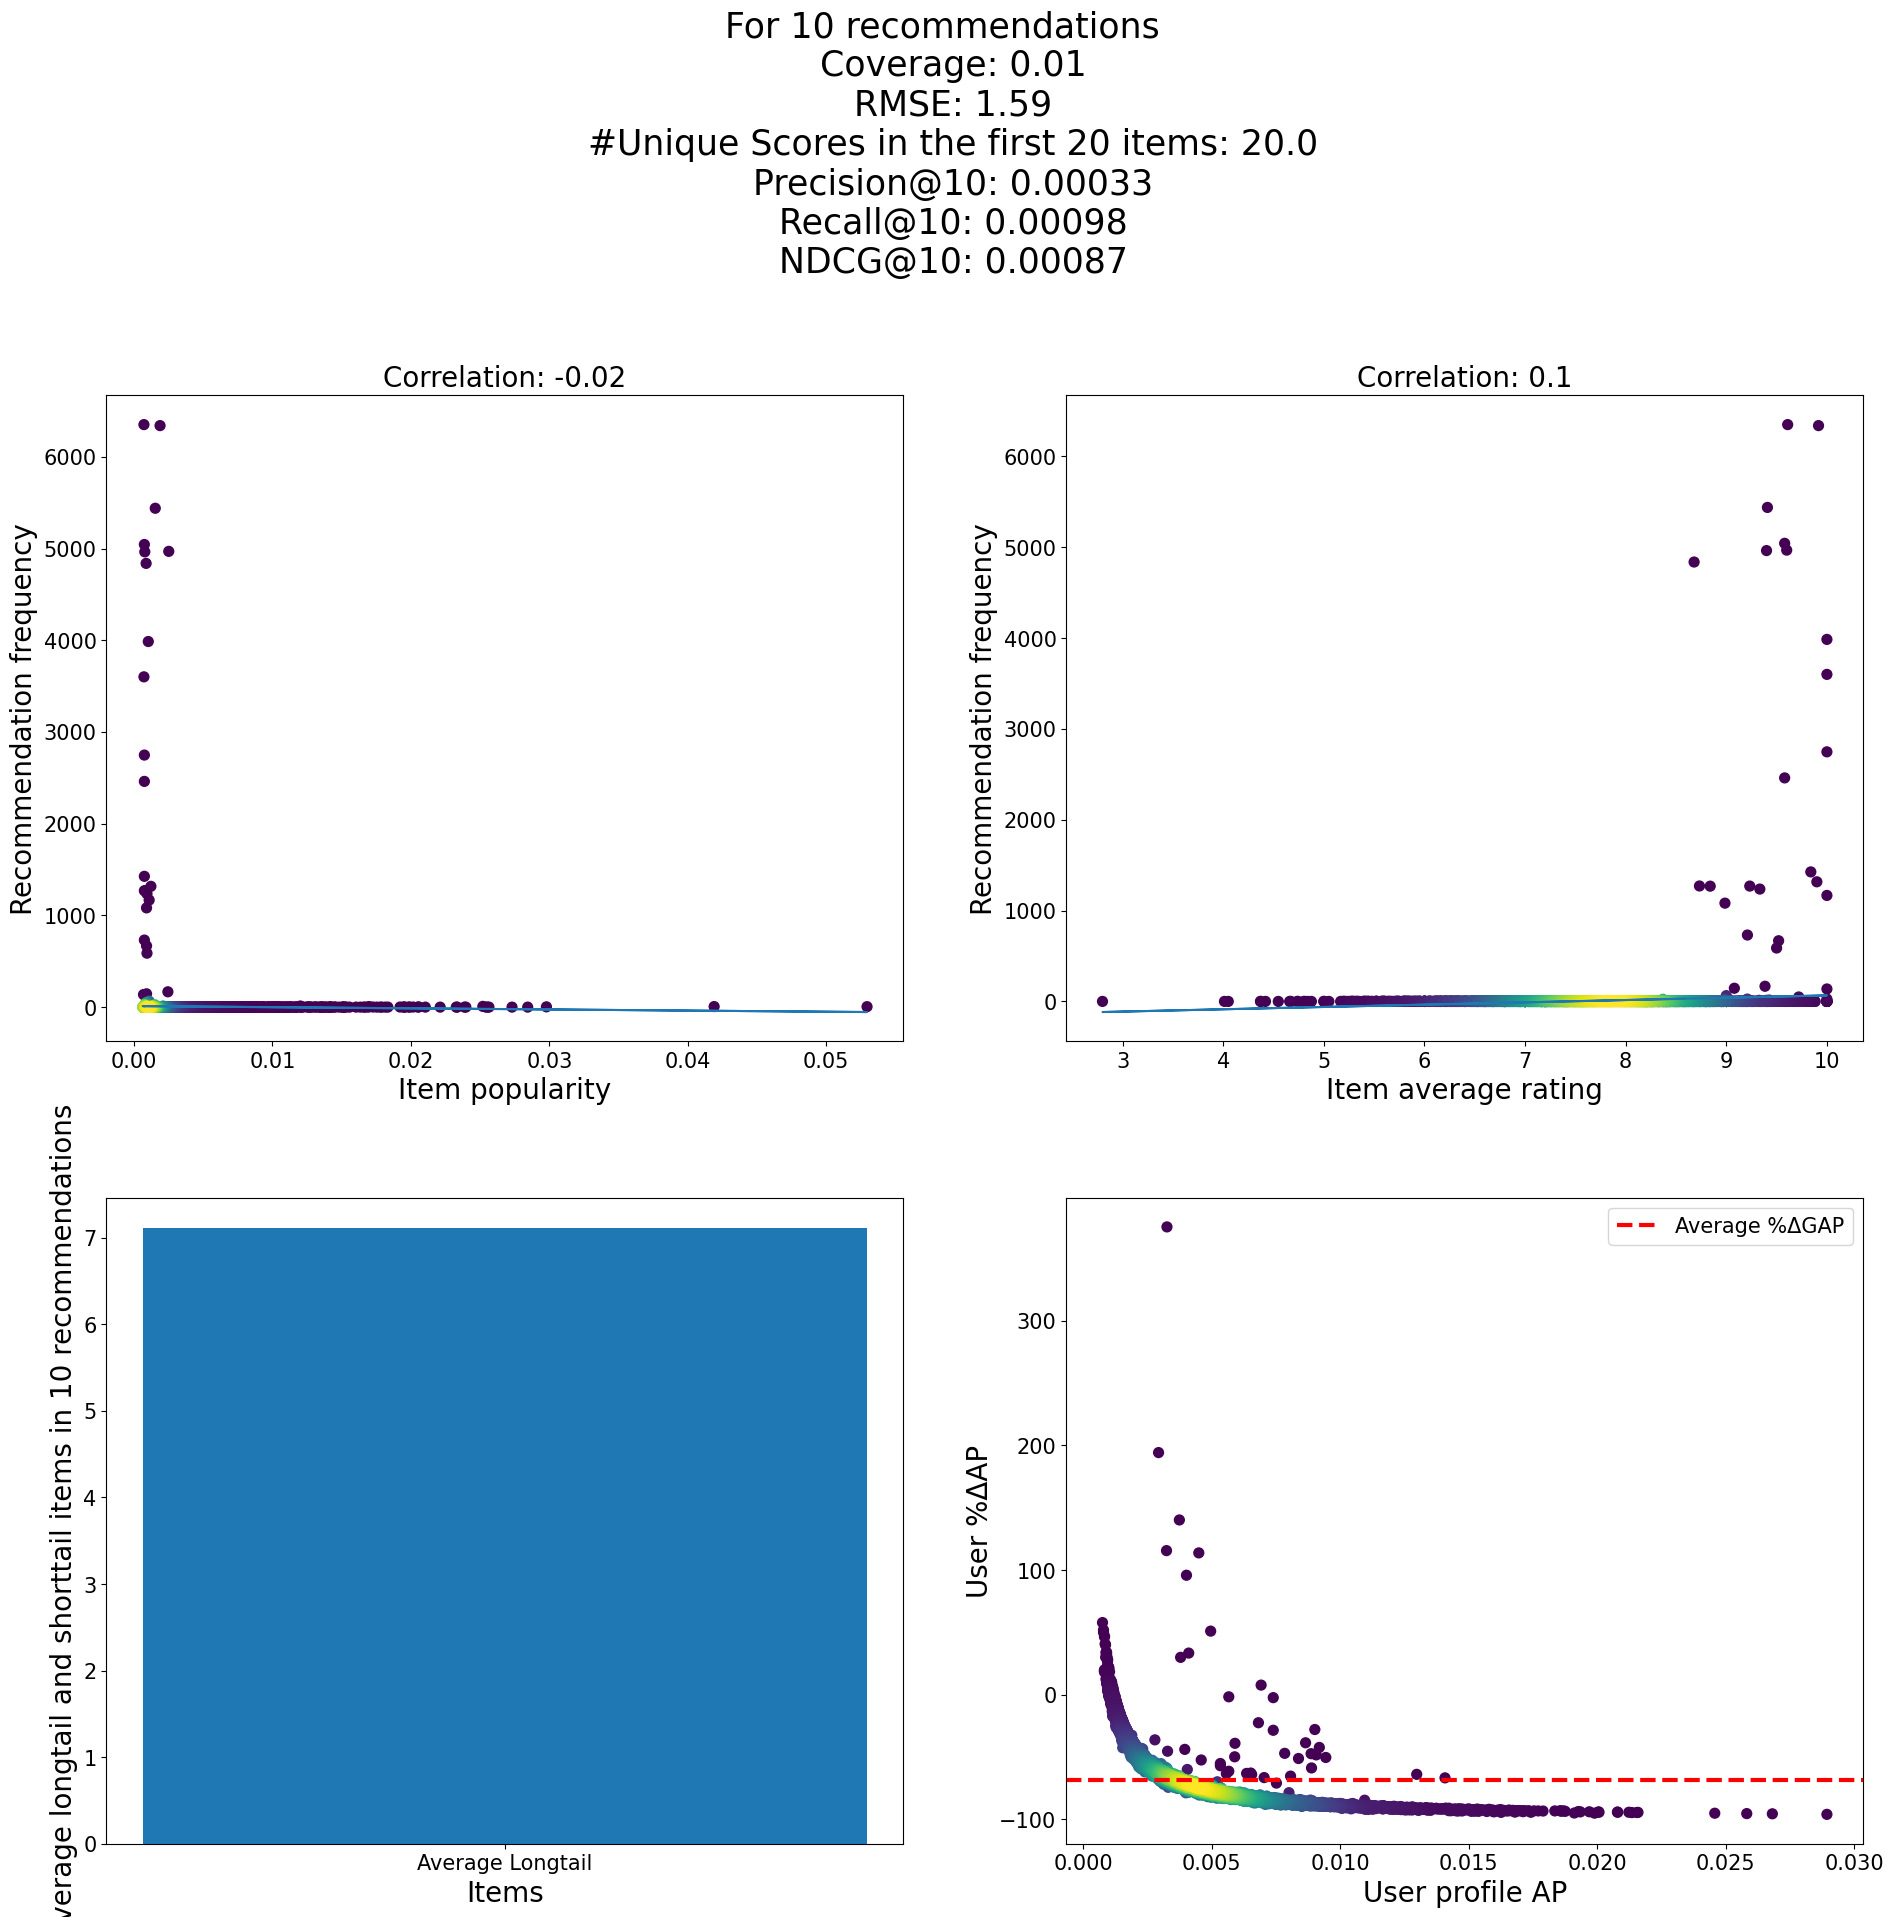

In [21]:
algorithm_cornac = MF
algo_name = "CornacMF"
versions = algo_versions[algo_name]


# for every 'fixed' version of the algorithm
for args in versions:
    print(data_strategy, args)

    p = "best_parameters/" + algo_name + "/" + data_strategy + "_" + str(args) + ".pkl"
    if os.path.isfile(p):
        print("We got them already")
        with open(p, "rb") as f:
            best_params = pickle.load(f)
    else:
        print("We have to compute them now")
        # optimize for this fixed version
        best_params = optimize_cornac(
            ratings=ratings, algorithm_name=algo_name, args=args, max_evals=20
        )

        # save the best parameters for this fixed version

        with open(
            "best_parameters/"
            + algo_name
            + "/"
            + data_strategy
            + "_"
            + str(args)
            + ".pkl",
            "wb",
        ) as f:
            pickle.dump(best_params, f)

    optimal_k = best_params["k"]
    optimal_reg = best_params["lambda_reg"]
    optimal_lr = best_params["learning_rate"]

    pop_biases_cornac, metrics_dict_cornac = modelling_mf.train_algorithm_cornac(
        algorithm=lambda: algorithm_cornac(
            k=optimal_k,
            use_bias=args["bias"],
            lambda_reg=optimal_reg,
            learning_rate=optimal_lr,
        ),
        algo_name=algo_name,
        ratings=ratings,
        evaluation_way=evaluation_way,
        verbose=verbose,
        n=nr_recs,
        sampling_strategy=sampling_strategy,
        partition_way=partition_way,
        plot=plot,
        data_strategy=data_strategy,
        args=args,
        save_plot=save_plot,
    )

    # Save metrics!
    with open(
        "experimental_results/"
        + algo_name
        + "/"
        + data_strategy
        + "_"
        + str(args)
        + ".pkl",
        "wb",
    ) as f:
        pickle.dump(metrics_dict_cornac, f)
    with open('experimental_results/'+algo_name+'/detailed_per_item_'+data_strategy+'_'+str(args)+'.pkl', 'wb') as f:
        pickle.dump(pop_biases_cornac, f)